# US Domestic Flights On-Time Performance
## by Prasanth Kadimisetty

## Investigation Overview

> In this Investigation, I wanted to look at the trend in delays and the on-time performance of all the  airlines which are operating in United States in the year 2012. I also tried to find which was the best time in 2012 to book a domestic flight to minimize the delays in our journeys.



## Dataset Overview

> The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS) tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled and diverted flights appears in DOT's monthly Air Travel Consumer Report, published about 30 days after the month's end, as well as in summary tables posted on this website. BTS started gathering details about the causes of flight delays in June 2003. Sypnosis of Data and raw data are made available to the public at the time the Air Travel Consumer Report is released.

> This data consists the all flight records in the year 2012. It has 6096762 rows and 34 columns. 13908 data points were removed due to inconsistencies and missing information.Attributes included arrival delay, departure delay , cancellation code, carrier name etc. 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Mount Google drive in Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# load in the dataset into a pandas dataframe
df=pd.read_csv("/content/gdrive/My Drive/datasets/air_2012.csv")
df.head()

,year,month,day_of_month,day_of_week,dep_time,crs_dep_time,arr_time,crs_arr_time,unique_carrier,tail_num,fl_num,actual_elapsed_time,crs_elapsed_time,air_time,dep_delay,arr_delay,origin,dest,distance,taxi_in,taxi_out,cancelled,cancellation_code,diverted,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2012,1,1,7,855.0,900.0,1142.0,1225.0,AA,N325AA,1,347.0,385.0,330.0,-5.0,-43.0,JFK,LAX,2475.0,4.0,13.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2012,1,2,1,921.0,900.0,1210.0,1225.0,AA,N319AA,1,349.0,385.0,325.0,21.0,-15.0,JFK,LAX,2475.0,11.0,13.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2012,1,3,2,931.0,900.0,1224.0,1225.0,AA,N323AA,1,353.0,385.0,319.0,31.0,-1.0,JFK,LAX,2475.0,22.0,12.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2012,1,4,3,904.0,900.0,1151.0,1225.0,AA,N320AA,1,347.0,385.0,309.0,4.0,-34.0,JFK,LAX,2475.0,20.0,18.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2012,1,5,4,858.0,900.0,1142.0,1225.0,AA,N338AA,1,344.0,385.0,306.0,-2.0,-43.0,JFK,LAX,2475.0,22.0,16.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [4]:
#change the dataypes of fl_num,cancelled and diverted columns to necessary datatypes
df=df.astype({'fl_num':str,'cancelled':int,'diverted':int})

In [5]:
#change the values of dep_time,arr_time,taxi_out,dep_delay when the flight is cancelled to null
df.loc[df.cancelled==1,'dep_time']=np.nan
df.loc[df.cancelled==1,'arr_time']=np.nan
df.loc[df.cancelled==1,'taxi_out']=np.nan
df.loc[df.cancelled==1,'dep_delay']=np.nan

In [6]:
#change the values of dep_time,arr_time,taxi_out,dep_delay when the flight is diverted to null
df.loc[df.diverted==1,'dep_time']=np.nan
df.loc[df.diverted==1,'arr_time']=np.nan
df.loc[df.diverted==1,'dep_delay']=np.nan
df.loc[df.diverted==1,'taxi_in']=np.nan
df.loc[df.diverted==1,'taxi_out']=np.nan

In [7]:
#Remove those datapoints where actual departure or arrival time is null
df=df[(df.crs_dep_time.notnull()) & (df.crs_arr_time.notnull())]

In [8]:
# Import airports lookup table from csv file to a Dataframe
airports=pd.read_csv('/content/gdrive/My Drive/datasets/airports.csv')
airports.head()

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


In [9]:
#Drop unnessessary columns
airports=airports[['iata','airport','city']]
airports.head()

,iata,airport,city
0,00M,Thigpen,Bay Springs
1,00R,Livingston Municipal,Livingston
2,00V,Meadow Lake,Colorado Springs
3,01G,Perry-Warsaw,Perry
4,01J,Hilliard Airpark,Hilliard


In [10]:
# Import carriers lookup table from csv file to a Dataframe
carr=pd.read_csv('/content/gdrive/My Drive/datasets/carriers.csv')

In [11]:
#inner join carriers Dataframe and main dataset on carrier code present in two tables
#Drop the repeated Code column
#rename the new columns as per our need
df=pd.merge(df,carr,left_on='unique_carrier',right_on='Code',how='inner')
df.drop(columns=['Code'],inplace=True)
df.rename(columns={'Description': 'carrier_name'},inplace=True)

In [12]:
#inner join airports Dataframe and main dataset on origin airport's iata code present in two tables
#Drop the repeated iata column
#rename the new columns to origin_airport and org_city to signify origin airport name and city 
df=pd.merge(df,airports,left_on='origin',right_on='iata')
df.drop(columns=['iata'],inplace=True)
df.rename(columns={'airport':'org_airport','city':'org_city'},inplace=True)

In [13]:
#inner join airports Dataframe and main dataset on destination airport's iata code present in two tables
#Drop the repeated iata column
#rename the new columns to dest_airport and dest_city to signify destination airport name and city 
df=pd.merge(df,airports,left_on='dest',right_on='iata')
df.drop(columns=['iata'],inplace=True)
df.rename(columns={'airport':'dest_airport','city':'dest_city'},inplace=True)

In [14]:
#replace a value in carrier name as it is very long and that extra part is irrelevant for our analysis
mask=df.carrier_name=='US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)'
df.loc[mask,'carrier_name']='US Airways Inc.'

In [15]:
#replace all the cancellation codes to their respective reasons for cancellation which are carrier,weather,NAS and Security 
df.loc[df.cancellation_code=='A','cancellation_code']='Carrier'
df.loc[df.cancellation_code=='B','cancellation_code']='Weather'
df.loc[df.cancellation_code=='C','cancellation_code']='National Air System'
df.loc[df.cancellation_code=='D','cancellation_code']='Security'
df.loc[df.cancellation_code=='N','cancellation_code']=np.NaN

In [16]:
#Display the info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6082854 entries, 0 to 6082853
Data columns (total 34 columns):
 #   Column               Dtype  
---  ------               -----  
 0   year                 int64  
 1   month                int64  
 2   day_of_month         int64  
 3   day_of_week          int64  
 4   dep_time             float64
 5   crs_dep_time         float64
 6   arr_time             float64
 7   crs_arr_time         float64
 8   unique_carrier       object 
 9   tail_num             object 
 10  fl_num               object 
 11  actual_elapsed_time  float64
 12  crs_elapsed_time     float64
 13  air_time             float64
 14  dep_delay            float64
 15  arr_delay            float64
 16  origin               object 
 17  dest                 object 
 18  distance             float64
 19  taxi_in              float64
 20  taxi_out             float64
 21  cancelled            int64  
 22  cancellation_code    object 
 23  diverted             int64  
 24

In [17]:
# drop unnesscessary which we dont use in plotting graphs  
df.drop(['air_time','crs_dep_time','crs_arr_time','unique_carrier','tail_num','fl_num','dep_time','arr_time','origin','dest'],axis=1,inplace=True)

In [18]:
# Display the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6082854 entries, 0 to 6082853
Data columns (total 24 columns):
 #   Column               Dtype  
---  ------               -----  
 0   year                 int64  
 1   month                int64  
 2   day_of_month         int64  
 3   day_of_week          int64  
 4   actual_elapsed_time  float64
 5   crs_elapsed_time     float64
 6   dep_delay            float64
 7   arr_delay            float64
 8   distance             float64
 9   taxi_in              float64
 10  taxi_out             float64
 11  cancelled            int64  
 12  cancellation_code    object 
 13  diverted             int64  
 14  carrier_delay        float64
 15  weather_delay        float64
 16  nas_delay            float64
 17  security_delay       float64
 18  late_aircraft_delay  float64
 19  carrier_name         object 
 20  org_airport          object 
 21  org_city             object 
 22  dest_airport         object 
 23  dest_city            object 
dty

## Behaviour of Flights Mid-Air

>  Mid air analysis is analysis of flight in the air i.e, flight can cover the departure delay and reach on time or early, it can increase or decrease the delay.

>  69.89% of flights speedup in the air to cover the delay, 27% of flights Increase the delay and 3.35% of flights maintain same delay as departure delay.


In [19]:
#count the flights which speedup , increase more delay or maintain same delay in mid air.
df['mid_air']=df['arr_delay']-df['dep_delay']
rows=df[df.mid_air.notnull()].shape[0]
nochange=df[df['mid_air']==0].shape[0]
speedup_no=df[(df['mid_air']<0) & (df['arr_delay']>0)].shape[0]
moredelay=df[df['mid_air']>0].shape[0]
speedup_crct=df[(df['mid_air']<0) & (df['arr_delay']==0)].shape[0]
speedup_bfr=df[(df['mid_air']<0) & (df['arr_delay']<0)].shape[0]
speedup=df[df['mid_air']<0].shape[0]


In [20]:
#calculate percentages of flights which speedup or increase delay or maintain same delay
print("Percentage of flights which speedup during the flight: {0:.2f}%".format((speedup/rows)*100))
print("Percentage of flights which further increase delay during the flight: {0:.2f}%".format((moredelay/rows)*100))
print("Percentage of flights maintain the same delay during the flight : {0:.2f}%".format((nochange/rows)*100))

Percentage of flights which speedup during the flight: 69.89%
Percentage of flights which further increase delay during the flight: 26.76%
Percentage of flights maintain the same delay during the flight : 3.35%


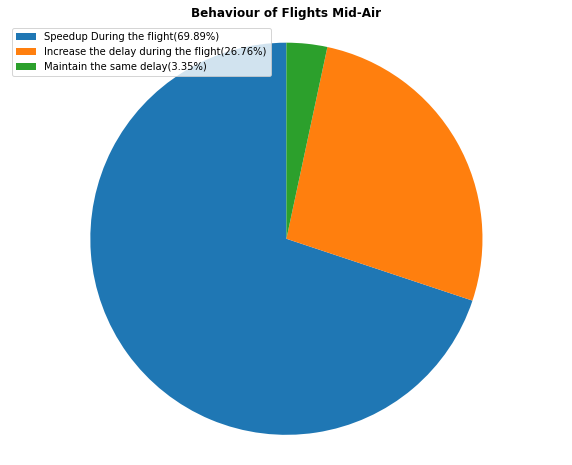

In [21]:
#Make a pie chart representing the percentages which we found above in our data.
data=[speedup,moredelay,nochange]
midairlist=['Speedup During the flight(69.89%)','Increase the delay during the flight(26.76%)','Maintain the same delay(3.35%)']
plt.figure(figsize =(10, 8)) 
patches, texts =plt.pie(data,startangle=90);
plt.legend(patches, midairlist,loc='best');
plt.title("Behaviour of Flights Mid-Air",fontweight="bold")
plt.axis('equal');

## Behaviour of Flights which Speedup in MidAir
>  78% of flights which speed up in the midair reach early than the actual arrival time, 1.29% of flights speedup and reach on time while 20.8% of fights  speedup but still get delayed.

In [22]:
#print percentage of flights which speedup and reach early or on time or still get delayed
print("Percentage of flights which speed up but still get delayed: {0:.2f}%".format((speedup_no/speedup)*100))
print("Percentage of flights which speed up to reach correct time: {0:.2f}%".format((speedup_crct/speedup)*100))
print("Percentage of flights which speed up and reach before the actual arrival time is : {0:.2f}%".format((speedup_bfr/speedup)*100))

Percentage of flights which speed up but still get delayed: 20.71%
Percentage of flights which speed up to reach correct time: 1.29%
Percentage of flights which speed up and reach before the actual arrival time is : 78.01%


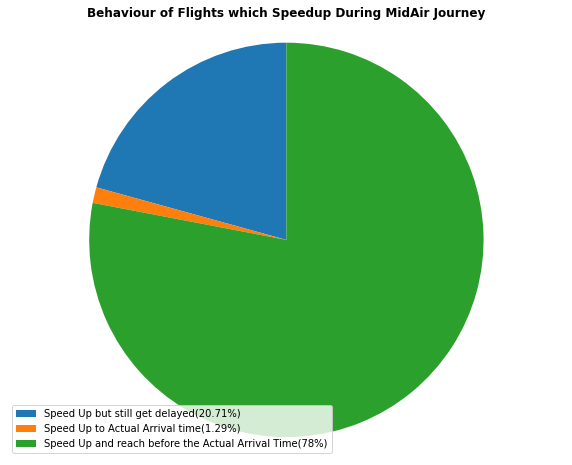

In [23]:
#make a pie chart representing the percentage of values which we found above
data=[speedup_no,speedup_crct,speedup_bfr]
speeduplist=['Speed Up but still get delayed(20.71%)','Speed Up to Actual Arrival time(1.29%)','Speed Up and reach before the Actual Arrival Time(78%)']
plt.figure(figsize =(10, 8)) 
patches, texts =plt.pie(data,startangle=90);
plt.legend(patches, speeduplist, loc="best");
plt.title("Behaviour of Flights which Speedup During MidAir Journey",fontweight="bold");
plt.axis('equal');

## Flights Cancelled by Airlines/Carriers

> Atlantic Southeast airlines cancelled highest no. of flights in 2012 i.e, 15257. Hawaiin Airlines cancelled least no. of flighst i.e, 67.

> Skywest Airlines and American Eagle Airlines stand in 2nd and 3rd position after Atlantic Southeast airlines by cancelling 11167  and 10373 flights respectively.

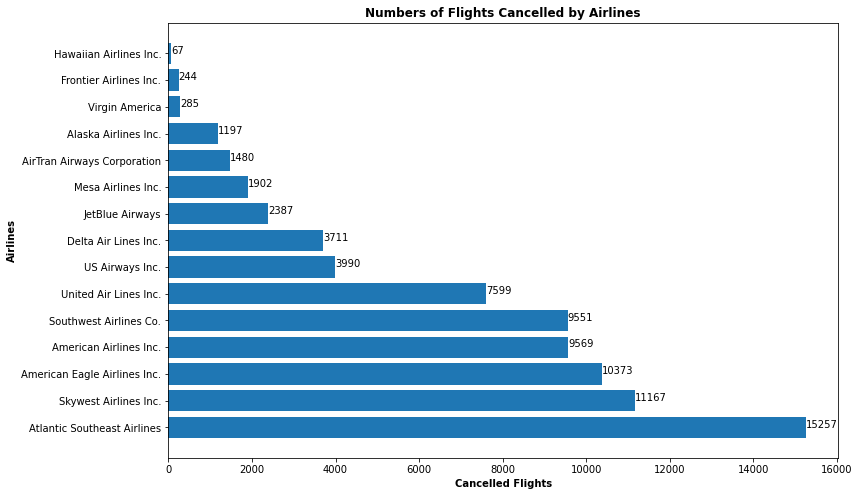

In [24]:
#plot a horizantal bar graph representing no. of flight operated by each carrier
cancelled_carriers=df[df.cancelled==1].carrier_name.value_counts()
plt.figure(figsize=(12,8))
plt.barh(cancelled_carriers.index,cancelled_carriers.values);
plt.xlabel('Cancelled Flights',fontweight="bold")
plt.ylabel('Airlines',fontweight="bold")
plt.title('Numbers of Flights Cancelled by Airlines',fontweight="bold")
for index, value in enumerate(cancelled_carriers.values):
     plt.text(value, index, str(value))

## Analysis across months

>  The no. flights operating is high in the month of __July__ and low in the month of __February__.There is a sharp rise in no. of flights operating from February to March and a sharp fall from August to September


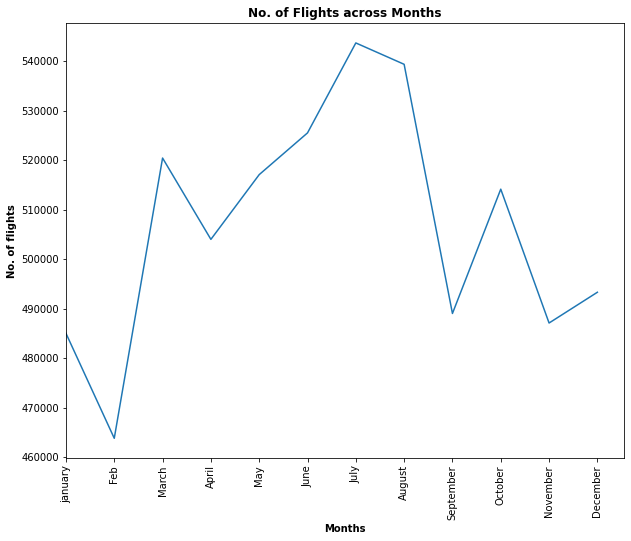

In [25]:
#plot a line char of no. of flights across months
plt.figure(figsize=(10,8))
mon=df.month.value_counts()
mon.sort_index(inplace=True)
plt.plot(mon.index,mon.values)
plt.xlabel("Months",fontweight="bold");
plt.ylabel('No. of flights',fontweight="bold")
plt.title("No. of Flights across Months",fontweight="bold")
plt.xticks(np.arange(13),('','january','Feb','March','April','May','June','July','August','September','October','November','December'),rotation=90);
plt.xlim(left=1);

> All the Average Delays are high in the month of July. It is may be because the no. of flights operating in the month of __July__ is high compared to other months.

>  The delay due to Security is negligible. The average delay due to late aircraft is very high compared to other types of delays.
 
 

> __Late Aircraft Delay > Carrier Delay > NAS Delay > Weather Delay  > Security Delay__

> __February,April and November__ may be the best months in 2012 to travel.



  

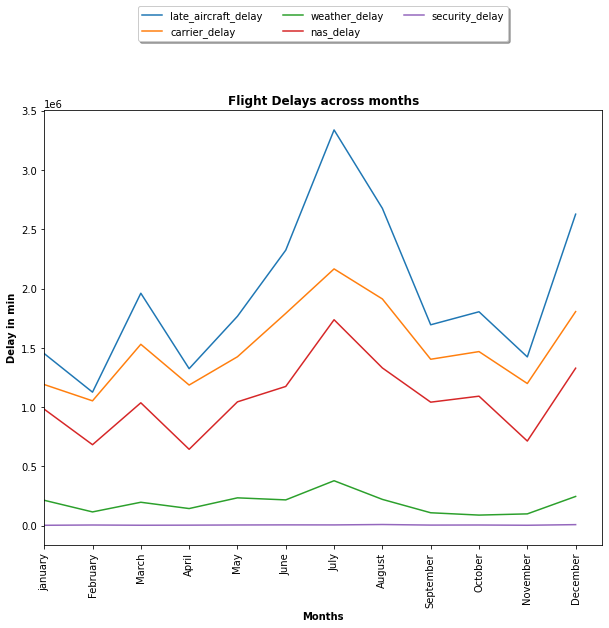

In [26]:
# filter some columns from our dataset and plot line charts for different types of delays across months
df2 = df.filter(['month','carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay'], axis=1)
df2 = df2.groupby('month')['late_aircraft_delay','carrier_delay','weather_delay','nas_delay','security_delay'].sum().plot(figsize=(10,8))
df2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True, shadow=True);
plt.title("Flight Delays across months",fontweight="bold");
plt.ylabel("Delay in min",fontweight="bold");
plt.xlabel("Months",fontweight="bold")
plt.xticks(np.arange(13),('','january','February','March','April','May','June','July','August','September','October','November','December'),rotation=90);
plt.xlim(left=1);


> The highest number of flights are cancelled in __October__. The least number of flights are cancelled in __September__.

> Though the probability of flight getting diverted is very less compared to cancellation. The no. of flights which got diverted is high in the month of __July__ and less in __February__.



In [27]:
# make a single column to represent whether the flight is cancelled or diverted
dfcd=df[(df.cancelled==1) | (df.diverted==1)]
dfcd=dfcd[['month','day_of_week','cancelled','diverted','cancellation_code','carrier_name']]
dfcd.loc[df.cancelled==1,'c_or_d']='cancelled'
dfcd.loc[df.diverted==1,'c_or_d']='diverted'

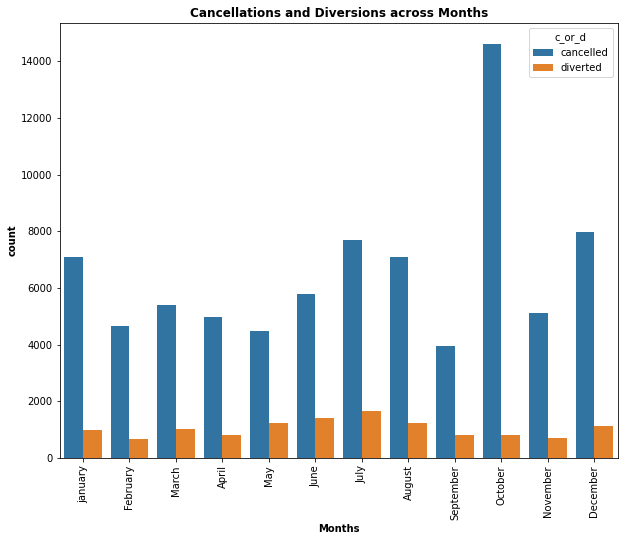

In [28]:
#plot a clustered bar char to compare cancelled and diverted flights each month
plt.figure(figsize=(10,8))
sb.countplot(data=dfcd,x='month',hue='c_or_d')
plt.xlabel("Months",fontweight="bold");
plt.ylabel("count",fontweight="bold");
plt.title("Cancellations and Diversions across Months",fontweight="bold");
plt.xticks(np.arange(12),('january','February','March','April','May','June','July','August','September','October','November','December'),rotation=90);

## Analysis Across Weekdays

> The no. flights operating is high on __Monday__ and low on __Saturday__ .There is a __sharp fall__ in the no. of flights operating from Friday to Saturday.

> Less flights operate in weekends(Saturday and Sunday) compared to weekdays(Monday-Friday)

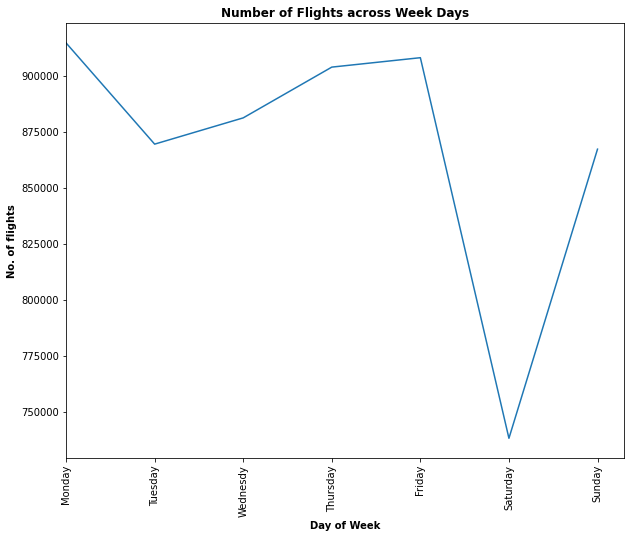

In [29]:
#plot line chart of no. of flights across weekdays
plt.figure(figsize=(10,8))
dfw=df.day_of_week.value_counts()
dfw.sort_index(inplace=True)
plt.plot(dfw.index,dfw.values)
plt.xlabel("Day of Week",fontweight="bold");
plt.ylabel('No. of flights',fontweight="bold")
plt.title("Number of Flights across Week Days",fontweight="bold")
plt.xticks(np.arange(8),("",'Monday','Tuesday','Wednesdy','Thursday','Friday','Saturday','Sunday'),rotation=90);
plt.xlim(left=1);

> All the Average Delays are high on __Friday and Monday__ . It is may be because the no. of flights operating on these days is high.

>  The delay due to __Security__ is negligible. The average delay due to late aircraft is very high compared to other types of delays.
 
 

> __Late Aircraft Delay > Carrier Delay > NAS Delay > Weather Delay  > Security Delay__

> As the no. of flights operating is less on saturdays. There are less chances for more delay compared to other days. Therefore __Saturday__ is best day to travel among the weekdays.


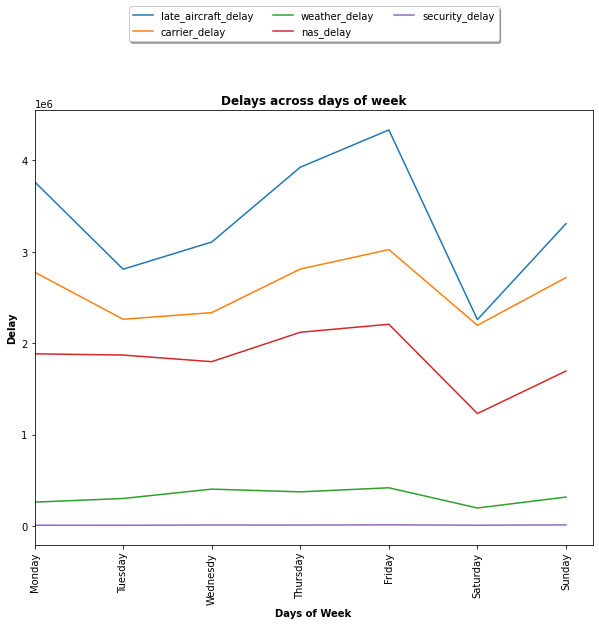

In [30]:
# filter some columns from our dataset and plot line charts for different types of delays across days of week.
df2 = df.filter(['day_of_week','carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay'], axis=1)
df2 = df2.groupby('day_of_week')['late_aircraft_delay','carrier_delay','weather_delay','nas_delay','security_delay'].sum().plot(figsize=(10,8))
df2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True, shadow=True);
plt.xlabel("Days of Week",fontweight="bold");
plt.ylabel("Delay",fontweight="bold")
plt.title("Delays across days of week",fontweight="bold")
plt.xticks(np.arange(8),("",'Monday','Tuesday','Wednesdy','Thursday','Friday','Saturday','Sunday'),rotation=90);
plt.xlim(left=1);

> Though the number of flights operating is high on __Monday__, the highest number of flights are cancelled on __Tuesday__. The least number of flights are cancelled on Saturday.

> The no. of flights diverted is approximately same on all days.



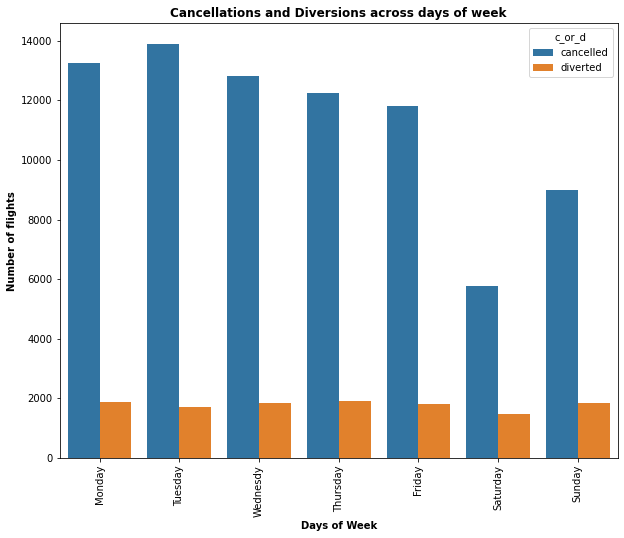

In [31]:
#plot a clustered bar char to compare cancelled and diverted flights each day of week in the whole year
plt.figure(figsize=(10,8))
sb.countplot(data=dfcd,x='day_of_week',hue='c_or_d')
plt.xlabel("Days of Week",fontweight="bold");
plt.ylabel("Number of flights",fontweight="bold");
plt.title("Cancellations and Diversions across days of week",fontweight="bold")
plt.xticks(np.arange(7),('Monday','Tuesday','Wednesdy','Thursday','Friday','Saturday','Sunday'),rotation=90);

## Top 5 Airports in US 

> These are the top5 airports ranked my no. of flight records. <br>**"William B Hartsfield-Atlanta Intl"** has most flight records approx 400000 stand in 1st position and **"Los Angeles International"** stand in 5th pos with arounf 200000 flight records.

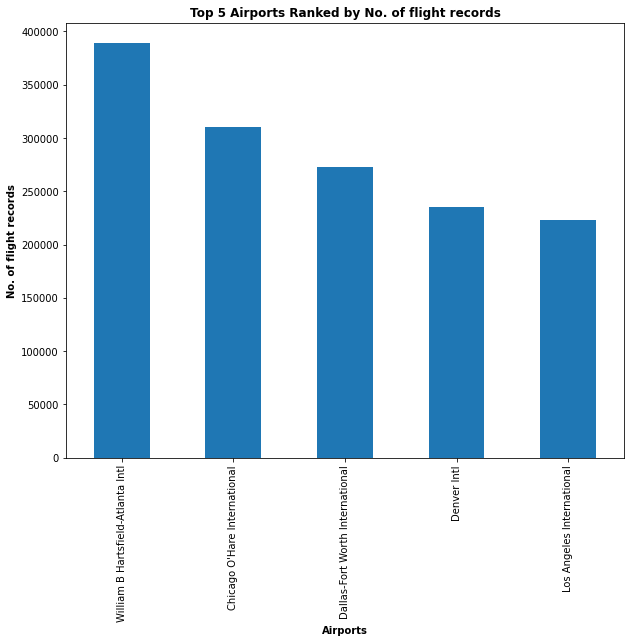

In [32]:
#Plot a Bar chart of top 5 airports ranked by no. of flight records.
plt.figure(figsize=(10,8))
topairports=df.org_airport.value_counts()[:5]
topairports.plot.bar(x=topairports.index);
plt.xticks(rotation=90);
plt.ylabel('No. of flight records',fontweight="bold")
plt.xlabel('Airports',fontweight="bold")
plt.title('Top 5 Airports Ranked by No. of flight records',fontweight="bold");

## Carrier Delay Analysis
> The top 5 Airlines (SouthWest Airlines,Atlantic Southeast Airlines,Delta Air Lines , Skywest Airlines and United Airlines) have mean carrier delay of **around 20 min perflight**. **SkyWest Airlines** done an amazing job with 13.4 min mean carrier delay per flight.

> Its really good to find that as we move from left to right across the bar chat the airlines with less no. of flights also done a good work. **Virgin Airlines** being in the last position have least mean carrier delay of **10 min per flight**.

> On the other hand, taking responsibility of a higher number of flights results in a higher chance of having an extreme waiting situation.


In [33]:
#count the no. of flight record of each carrier
ca=df.carrier_name.value_counts()
df.groupby('carrier_name').carrier_delay.mean()

carrier_name
AirTran Airways Corporation     11.118802
Alaska Airlines Inc.            16.738959
American Airlines Inc.          19.502196
American Eagle Airlines Inc.    19.212559
Atlantic Southeast Airlines     22.308218
Delta Air Lines Inc.            21.166746
Frontier Airlines Inc.          12.738385
Hawaiian Airlines Inc.          33.043768
JetBlue Airways                 20.864917
Mesa Airlines Inc.              17.467791
Skywest Airlines Inc.           13.442720
Southwest Airlines Co.          14.364177
US Airways Inc.                 15.269817
United Air Lines Inc.           18.978733
Virgin America                  10.016326
Name: carrier_delay, dtype: float64

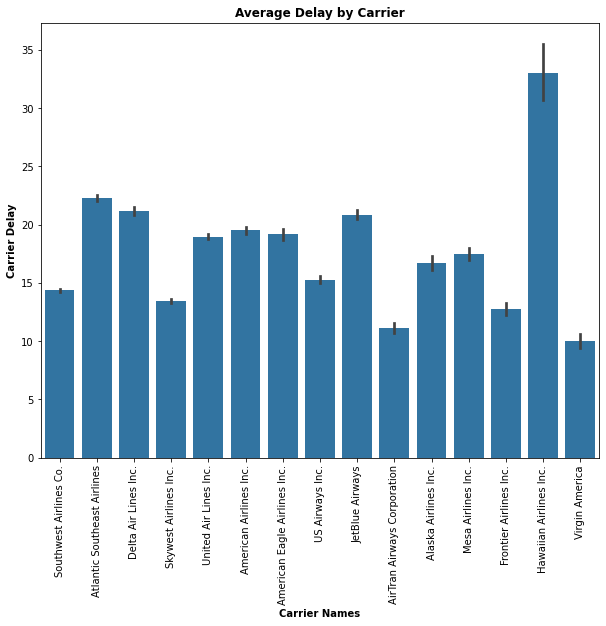

In [34]:
#plot a bar chart of average carrier delays of all the carriers present ranked by no. of flights operated.
base_color=sb.color_palette()[0]
plt.figure(figsize=(10,8))
sb.barplot(data=df,x='carrier_name',y='carrier_delay',color=base_color,order=ca.index);
plt.xticks(rotation=90);
plt.xlabel("Carrier Names",fontweight="bold");
plt.ylabel("Carrier Delay",fontweight="bold");
plt.title("Average Delay by Carrier",fontweight="bold");

The Average Arrival delay is Less or equal to Average Departure delay of any carrier.

> The Average **Arrival Delay** is least for **Alaska Airlines Inc.** and highest for  **Frontier Airlines Inc.**


> The Average **Departure Delay** is least for **Hawaiian Airlines Inc.** and highest for **United Airlines Inc.**


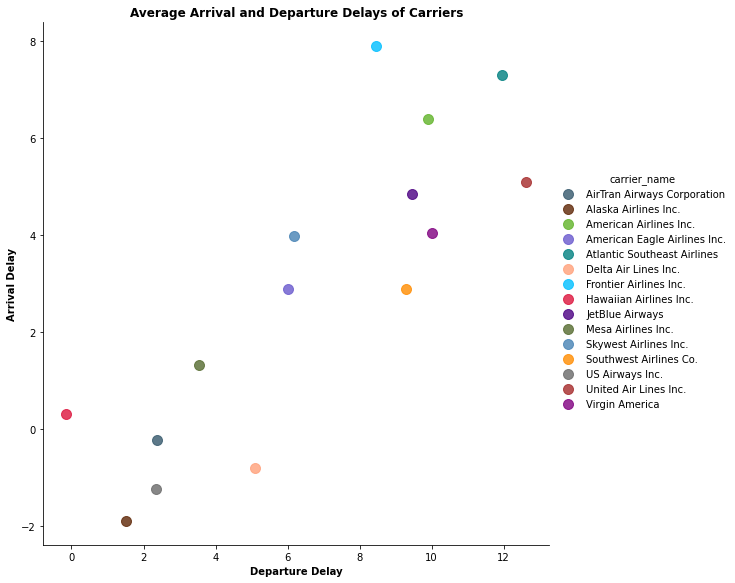

In [35]:
#make a scatter plot of average arrival delay and departure delay of all carriers encoded as color.
colors=['#35586C','#5E2605','#61B329','#6959CD','#008080','#FFA07A','#00BFFF','#DC143C','#4B0082','#556B2F','#4682B4','#FF8C00','#696969','#A52A2A','#800080']
sb.set_palette(sb.color_palette(colors))
carrier_averages = df.groupby('carrier_name').agg({'dep_delay':'mean', 'arr_delay':'mean'}).reset_index()
sb.lmplot('dep_delay', 'arr_delay', data=carrier_averages,
           fit_reg=False, hue='carrier_name',height=8,aspect=1,scatter_kws={"s": 100});
plt.xlabel("Departure Delay",fontweight="bold");
plt.ylabel("Arrival Delay",fontweight="bold");
plt.title("Average Arrival and Departure Delays of Carriers",fontweight="bold");